In [31]:
# %load ../../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')



### Load Data

----------------------------------------------------
DATA
Training Data X: (12, 2)
Traingin Data y: (12, 1)
Cross validation Data X: (21, 2)
Cross validation Data y: (21, 1)


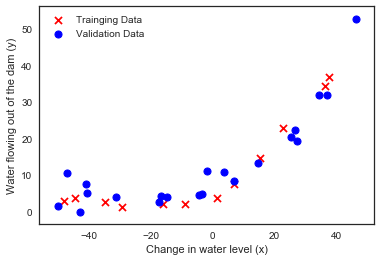

In [32]:
data = loadmat('ex5data1.mat')

y_train = data['y']
X_train = np.c_[np.ones_like(data['X']), data['X']]

y_val = data['yval']
X_val = np.c_[np.ones_like(data['Xval']), data['Xval']]
print('----------------------------------------------------')
print('DATA')
print('Training Data X:', X_train.shape)
print('Traingin Data y:', y_train.shape)
print('Cross validation Data X:', X_val.shape)
print('Cross validation Data y:', y_val.shape)

plt.figure()
plt.scatter(X_train[:,1], y_train, s = 50, c = 'r', marker = 'x', linewidths = 1)
plt.scatter(X_val[:,1], y_val, s = 50, c = 'b', marker = 'o', linewidths = 1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.legend(('Trainging Data','Validation Data'))

### Regularised Cost Function

regularised linear regression
Note: \theta_0 is not to be regularised adn is calcualted seperately when using the vertorised method

Regularized Cost Function
$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\big[y^{(i)} log( h_\theta(x^{(i)}))+(1-y^{(i)})log(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j = 1}^{n}\theta_{j}^{2}$$


Vectorized Cost Function
$$ J(\theta) = -\frac{1}{m}\big((log(h)^Ty+(log(1-h)^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j = 1}^{n}\theta_{j}^{2}$$

Partial derivative:
$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} \frac{\lambda}{m}\theta_{j}^{2}$$

Vectorized Partial Derivative
$$\frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(h-y) + \frac{\lambda}{m}\theta_{j}^{2}$$

Gradient Descent: Repeat until converge
$$\theta_0 : = \theta_0- \alpha\frac{1}{m}\frac{\delta J(\theta)}{\delta\theta_{0}}$$

$$\theta_j : = \theta_j- \alpha\Big[\Big(\frac{1}{m}\frac{\delta J(\theta)}{\delta\theta_{j}}\Big) + \frac{\lambda}{m}\theta_{j}\Big] j\epsilon{1,2,3...n}$$
                                

In [21]:

def linearRegCostFunction(theta, X, y, Lambda):
    m = X.shape[0]
    
    h = X.dot(theta)
    #cost funtion
    J = (1/(2 * m)) * np.sum(np.square(h - y)) + (Lambda/(2 * m)) * np.sum(np.square(theta[1:]))
   
    return(J)


def lrgradientReg(theta, X, y, Lambda):
    m = y.size
    
    h = X.dot(theta.reshape(-1,1))
        
    grad = (1/m) * (X.T.dot(h - y)) + (Lambda / m) * np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

initial_theta = np.ones((X_train.shape[1],1))
cost = linearRegCostFunction(initial_theta, X_train, y_train, 0)
gradient = lrgradientReg(initial_theta, X_train, y_train, 0)

print('Results')
print('Cost at theta = [1,1]: %.2f'%(cost))
print('Gradient at theta = [1,1]: %.2f , %.2f'%(gradient[0],gradient[1]))

def trainLinearReg(X, y, Lambda):
    #initial_theta = np.zeros((X.shape[1],1))
    initial_theta = np.array([[1],[1]])
        
    res = minimize(linearRegCostFunction, initial_theta, args = (X_train,y_train,Lambda), method = None, jac = lrgradientReg,
                   options = {'maxiter':5000})
    
    return(res)


Results
Cost at theta = [1,1]: 303.95
Gradient at theta = [1,1]: -15.30 , 598.17


### Regularised Cost Function using Scikit-learn



fitting parameters of linear regression with regaularisation
Lambda  = 0
theta0 = 8.76
theta1 = 0.23
other parameters:
      fun: 1285.0884851841522
 hess_inv: array([[1.02731204, 0.00634135],
       [0.00634135, 0.00120857]])
      jac: array([ -3.6472391, -92.1177481])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 102
      nit: 3
     njev: 90
   status: 2
  success: False
        x: array([8.75688344, 0.2333203 ])
[13.08790351  0.36777923]


fitting parameters of linear regression with sklearn.linear
theta0 = 13.09
theta1 = 0.37
Cost = 1604.40


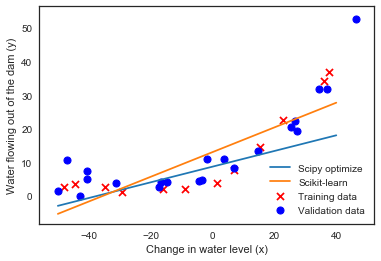

In [22]:

#fit the linear regression using minimize 
fit = trainLinearReg(X_train, y_train, 0)
print('\n\nfitting parameters of linear regression with regaularisation')
print('Lambda  = 0')
print('theta0 = %.2f'%(fit.x[0]))
print('theta1 = %.2f'%(fit.x[1]))
print('other parameters:')
print(fit)

# fit using linear regression from sklearn
regr = LinearRegression(fit_intercept = False)
regr.fit(X_train,y_train.flatten())
print(regr.coef_)
print('\n\nfitting parameters of linear regression with sklearn.linear')
print('theta0 = %.2f'%(regr.coef_[0]))
print('theta1 = %.2f'%(regr.coef_[1]))
print('Cost = %.2f'%(linearRegCostFunction(regr.coef_, X_train, y_train, 0)))

#compere 2 methods of fitting
plt.figure()
plt.plot(np.linspace(-50,40), (fit.x[0]+ (fit.x[1]*np.linspace(-50,40))), label = 'Scipy optimize')
plt.plot(np.linspace(-50,40), (regr.coef_[0]+ (regr.coef_[1]*np.linspace(-50,40))), label='Scikit-learn')
plt.scatter(X_train[:,1], y_train, s = 50, c = 'r', marker ='x', linewidths = 1,label = 'Training data')
plt.scatter(X_val[:,1], y_val, s = 50, c = 'b', marker = 'o', linewidths = 1,label = 'Validation data')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.legend(loc = 4);


### Learnign Curve

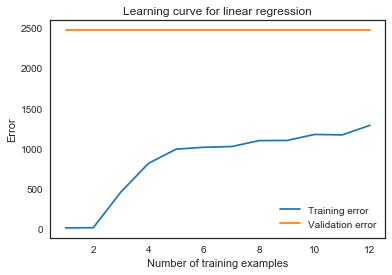

In [30]:
def learningCurve(X, y, Xval, yval, reg):
    m = y.size
    
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    
    for i in np.arange(m):
        res = trainLinearReg(X[:i + 1], y[:i + 1], reg)
        error_train[i] = linearRegCostFunction(res.x, X[:i + 1], y[:i + 1], reg)
        error_val[i] = linearRegCostFunction(res.x, Xval, yval, reg)
    
    return(error_train, error_val)


t_error, v_error = learningCurve(X_train, y_train, X_val, y_val, 0)


plt.plot(np.arange(1,13), t_error, label='Training error')
plt.plot(np.arange(1,13), v_error, label='Validation error')
plt.title('Learning curve for linear regression')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend();

### Polynomial regression (Scikit-learn)

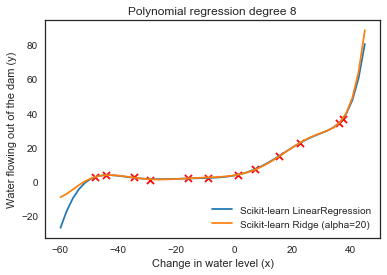

In [35]:
poly = PolynomialFeatures(degree=8)
X_train_poly = poly.fit_transform(X_train[:,1].reshape(-1,1))

regr2 = LinearRegression()
regr2.fit(X_train_poly, y_train)

regr3 = Ridge(alpha = 20) #Linear least squares with l2 regularization.
regr3.fit(X_train_poly, y_train)

# plot range for x
plot_x = np.linspace(-60,45)
# using coefficients to calculate y
plot_y = regr2.intercept_+ np.sum(regr2.coef_*poly.fit_transform(plot_x.reshape(-1,1)), axis=1)
plot_y2 = regr3.intercept_ + np.sum(regr3.coef_*poly.fit_transform(plot_x.reshape(-1,1)), axis=1)

plt.plot(plot_x, plot_y, label='Scikit-learn LinearRegression')
plt.plot(plot_x, plot_y2, label='Scikit-learn Ridge (alpha={})'.format(regr3.alpha))
plt.scatter(X_train[:,1], y_train, s=50, c='r', marker='x', linewidths=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial regression degree 8')
plt.legend(loc=4);

